> ## ❓Questions
> - How do we implement tree-based and distance-based methods in Python?
>
> ## ☑︎ Objectives
> - Fit a RF and KNN model to our data
> - Explore the effect of hyperparameters on model fit



## Random forest regression. K nearest neighbor regression

In [1]:
import os
current_work_dir = %pwd
MLPY_ROOT = current_work_dir.split('course')[0]
NOTEBOOK_FOLDER = os.path.join(MLPY_ROOT, 'course',  'notebooks')
MODELS_FOLDER = os.path.join(NOTEBOOK_FOLDER, 'models')

import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# when delivering live coding, these libraries and code in this cell have already been loaded
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import exp10
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer

from sklearn.utils import resample

# Make sure some warnings only print once
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.simplefilter(action='once', category=ConvergenceWarning)
warnings.simplefilter(action='once', category=DataConversionWarning)


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# load from previous lessons
cached_files = [
    'ames_train_y.pickle', 'ames_test_y.pickle',
    'ames_train_X.pickle', 'ames_test_X.pickle',
    'predictors.pickle', 'ames_ols_all.pickle',
    'ames_ridge.pickle', 'ames_lasso.pickle', 
    'ames_enet.pickle', 
    'ames_pcr.pickle', 'ames_plsr.pickle'
]

for file in cached_files:
    with open(os.path.join(MODELS_FOLDER, file), 'rb') as f:
        objectname = file.replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

# transformation function for Y
log_transf_f = FunctionTransformer(
    func=np.log10,
    inverse_func=exp10,
    validate=True
)

# function to create scores dataframe
def assess_model_fit(models, model_labels, datasetX, datasetY):
    columns = ['RMSE', 'R2', 'MAE']
    results = pd.DataFrame(0.0, columns=columns, index=model_labels)
    y_actual = log_transf_f.inverse_transform(datasetY.reshape(-1, 1))
    for i, method in enumerate(models):
        tmp_dataset_X = datasetX
        # while we build the model and predict on the log10Transformed 
        # sale price, we display the error in dollars as that makes more sense
        y_pred = log_transf_f.inverse_transform(method.predict(datasetX).reshape(-1, 1))
        results.iloc[i,0] = np.sqrt(mean_squared_error(y_actual, y_pred))
        results.iloc[i,1] = r2_score(y_actual, y_pred)
        results.iloc[i,2] = mean_absolute_error(y_actual, y_pred)
    return results.round(3)

# Plot coefficients/feature importances
def plot_coefficients(model, labels):
    # Support both regression/regularised regression and 
    #   random forest models
    if hasattr(model, 'coef_'):
        coefs = model.coef_.ravel()
        title = 'Estimated coefficients'
    elif hasattr(model, 'feature_importances_'):
        coefs = model.feature_importances_
        title = 'Feature importances'
    table = pd.Series(coefs, index = labels)
    # Get the largest 20 values (by absolute value)
    table = table[table.abs().nlargest(20).index].sort_values()

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title(title + ' (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

## Random Forest
In random forest, each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features.

In [2]:
# tuning grid was defined to optimise the following RF parameters:
param_grid = {"n_estimators": list(np.arange(10, 160, 10)),
            'max_depth': list(np.arange(3, 11, 1)),
            'min_samples_split': [0.005, 0.01, 0.02],
             'max_features': ['sqrt', 1.0]}

This was optimised in advance, and the best outcome of this ended up being:

```
{'max_depth': 9, 'min_samples_split': 0.005, 
'max_features': 1.0, 'n_estimators': 150}

# best score
0.8735794018428228
```

Tuning a grid of multiple parameters (and multiple values for each parameter) can take a long time:
each new parameter value **multiplies** the number of models that have to
be fitted.

For the sake of time, we won't actually tune the model here, but see below for some tips
on tuning large parameter grids.

In [3]:
from sklearn.ensemble import RandomForestRegressor

ames_rf = Pipeline([
    ('estimator', RandomForestRegressor(n_estimators=150, 
                                       max_depth = 9,
                                       min_samples_split = 0.005,
                                       max_features = 1.0))
    # If we want to actually tune these parameters
    # ('estimator', GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=5, n_jobs=-1))
])

ames_rf.fit(ames_train_X, ames_train_y.ravel())
# Save model for later notebooks
pickle.dump(ames_rf, open(os.path.join(MODELS_FOLDER, 'ames_rf.pickle'), 'wb'))

> ## ↔️ Extension: Tuning large parameter grids
>
> If you do want to do a grid search over multiple parameters, here are some tips/strategies:
>
> - Use **parallel processing**: `GridSearchCV` has a `n_jobs` argument that allows you to fit
>   multiple models in parallel: `n_jobs=-1` uses all your computer's cores. If you have a
>   modern computer with multiple CPU cores and plenty of RAM (memory), you may be able
>   to tune fairly large grids this way
> - Use the university's [High Performance Computing](https://www.sydney.edu.au/research/facilities/sydney-informatics-hub/digital-research-infrastructure.html)
>   facilities, e.g. Artemis, for jobs that you can't tackle with your local computer.
> - Some models (e.g. `xgboost`) may be able to make use of GPUs for much faster parallel
>   processing - but this can be hard to set up. Aim to train on a GPU only if you're
>   sure you can't use a CPU for your model.

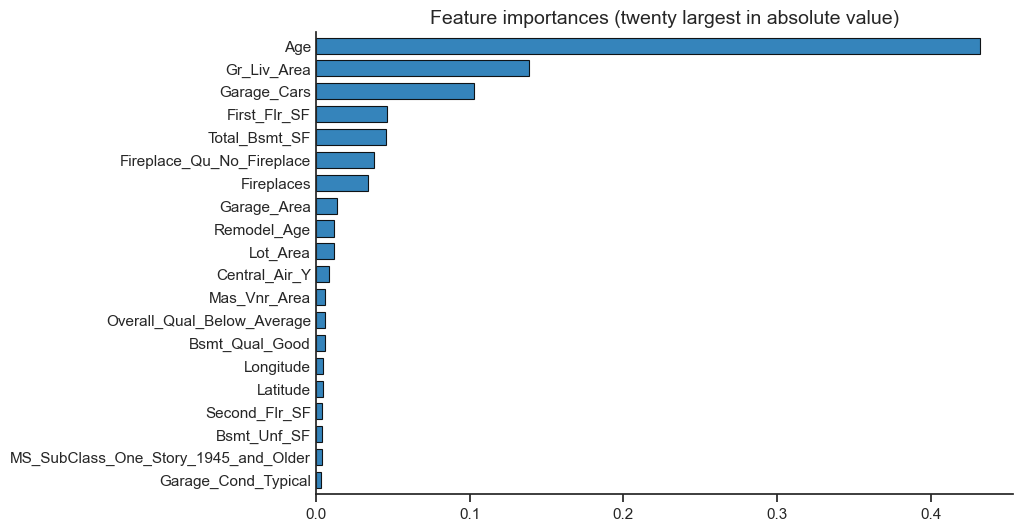

In [4]:
plot_coefficients(ames_rf['estimator'], predictors)
plt.show()

> ℹ️ The plot above shows the impurity-based feature importances, which are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

One disadvantage of impurity-based feature importances is that this can be biased towards features with many unique values (high cardinality). To overcome this bias one can perform a permutation feature importance as shown below (this might take a bit longer to run)

> 🗒️  Note that feature importance based on permutations are model-agnostic and can be applied for other models as well. 

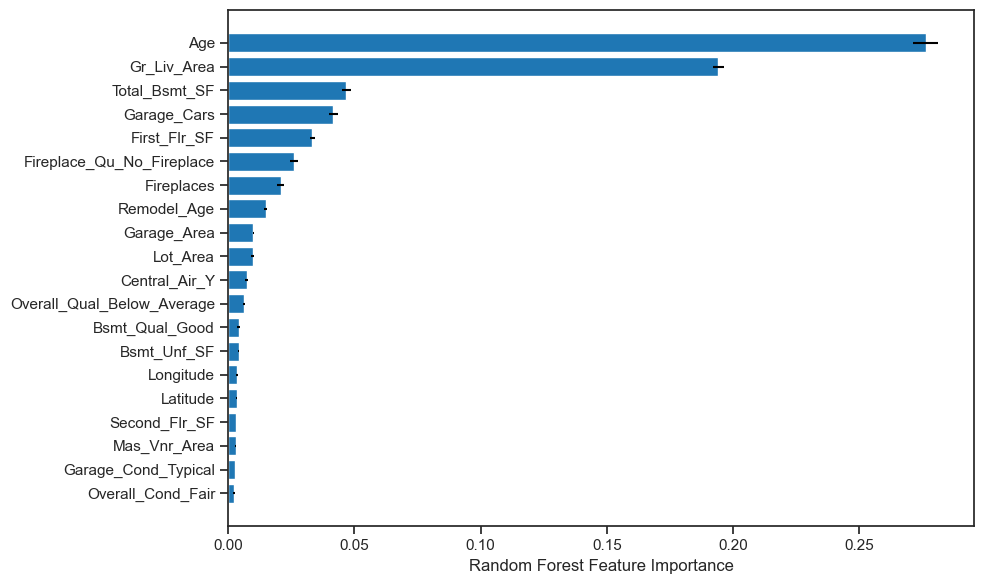

In [5]:
from sklearn.inspection import permutation_importance

perm_res = permutation_importance(ames_rf, ames_train_X, ames_train_y, n_repeats=5, random_state=0, n_jobs=2)
corrcoef_rf = np.asarray(perm_res.importances_mean)
corrcoef_rf_std = np.asarray(perm_res.importances_std)
#Select 20 largest only
sorted_idx = corrcoef_rf.argsort()[-20:]
fig, ax = plt.subplots(figsize = (10,6))
bar = ax.barh(np.arange(20), corrcoef_rf[sorted_idx], xerr = corrcoef_rf_std[sorted_idx],
 tick_label = np.asarray(predictors)[sorted_idx], align='center')
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()

## k-Nearest Neighbours Regression

Again, for the sake of time, we will not tune the k-nearest neighbours model over a large grid.
The parameters below show an example of how you might tune the parameters over a larger grid.
In actual analyses, you want to search over a large grid to ensure you've found the optimal
parameters.

In [6]:
# Grid that searches over a range of n_neighbors
param_grid = {
    "n_neighbors": list(np.arange(3,21,2)),
    "weights": ['uniform','distance'],
}

# Results from tuning:
# print(ames_kNN.named_steps['estimator'].best_score_)
# 0.7842456772785913
# KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=7, p=2, weights='distance')

Here, we'll just tune over a smaller grid (centred around the optimal value for `n_neighbors` we found in advance):

In [7]:
from sklearn.neighbors import KNeighborsRegressor

# Next, let's try to tune locally, trying 6, 7 and 8 neighbors:
param_grid = {"n_neighbors": [6,7,8],
              "weights": ['uniform']}


ames_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', GridSearchCV(KNeighborsRegressor(), 
                               param_grid, scoring='r2', cv=10))
])

ames_knn.fit(ames_train_X, ames_train_y)
# Save model for later notebooks
pickle.dump(ames_knn, open(os.path.join(MODELS_FOLDER, 'ames_knn.pickle'), 'wb'))
    
print(ames_knn.named_steps['estimator'].best_estimator_)
print(ames_knn.named_steps['estimator'].best_score_)

KNeighborsRegressor(n_neighbors=7)
0.778996444922293


## Compare Models

In [8]:
# What was the RMSE on the training data?
compare_train = assess_model_fit(
    models=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr,
            ames_plsr, ames_rf, ames_knn],
    model_labels=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR', 'RF', 'kNN'],
    datasetX=ames_train_X,
    datasetY=ames_train_y)
compare_train.sort_values('RMSE')

,RMSE,R2,MAE
OLS,15751.090,0.961,10933.508
RF,16230.942,0.958,10967.851
Lasso,16480.809,0.957,11448.829
Ridge,16493.543,0.957,11463.828
PLSR,16518.167,0.957,11608.870
PCR,16720.819,0.956,11742.761
ENet,16954.015,0.954,11758.565
kNN,31067.840,0.847,19718.647


In [9]:
def rearrange_df(df):
    out_df = (
        df.copy()
        .reset_index()
        .melt(
            id_vars='index',
            value_vars=df.columns.values.tolist(),
            var_name='metric',
            value_name='number'
        )
        .sort_values('number')
    )
    out_df['index'] = out_df['index'].astype(str)
    out_df= out_df.rename(columns={'index':'model_features'})
    return out_df

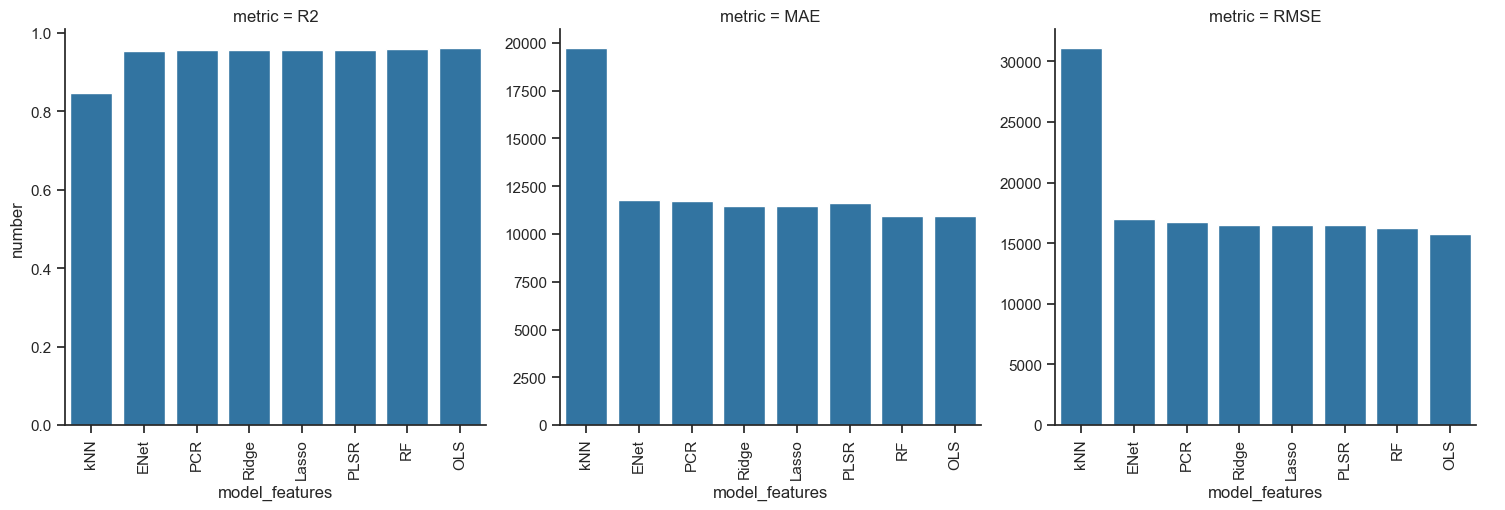

In [10]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(compare_train),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);

In [11]:
# What was the RMSE on the testing data?
compare_test = assess_model_fit(
    models=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, 
            ames_pcr, ames_plsr, ames_rf, ames_knn],
    model_labels=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR', 'RF', 'kNN'],
    datasetX=ames_test_X,
    datasetY=ames_test_y)
compare_test.sort_values('RMSE')

,RMSE,R2,MAE
Lasso,19864.494,0.933,13120.146
ENet,19886.108,0.933,13273.617
Ridge,20055.583,0.931,13284.272
PLSR,20094.727,0.931,13376.642
OLS,20602.458,0.928,13355.654
PCR,21070.227,0.924,13970.892
RF,27210.760,0.874,16782.609
kNN,34692.512,0.795,23087.591


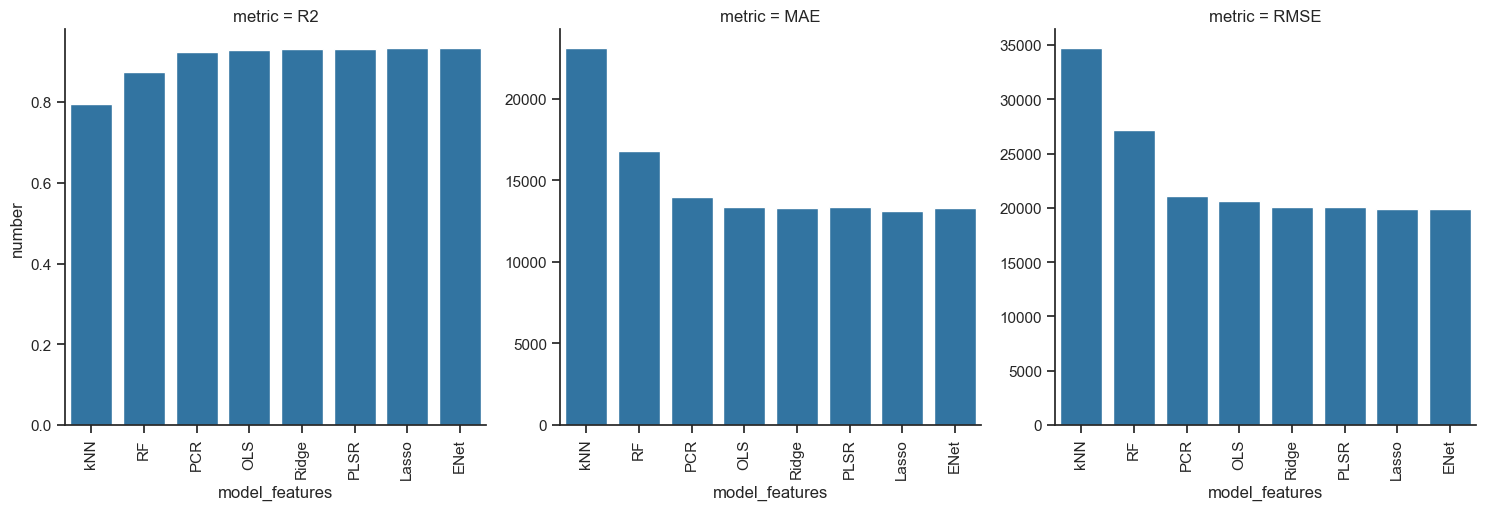

In [12]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(compare_test),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);

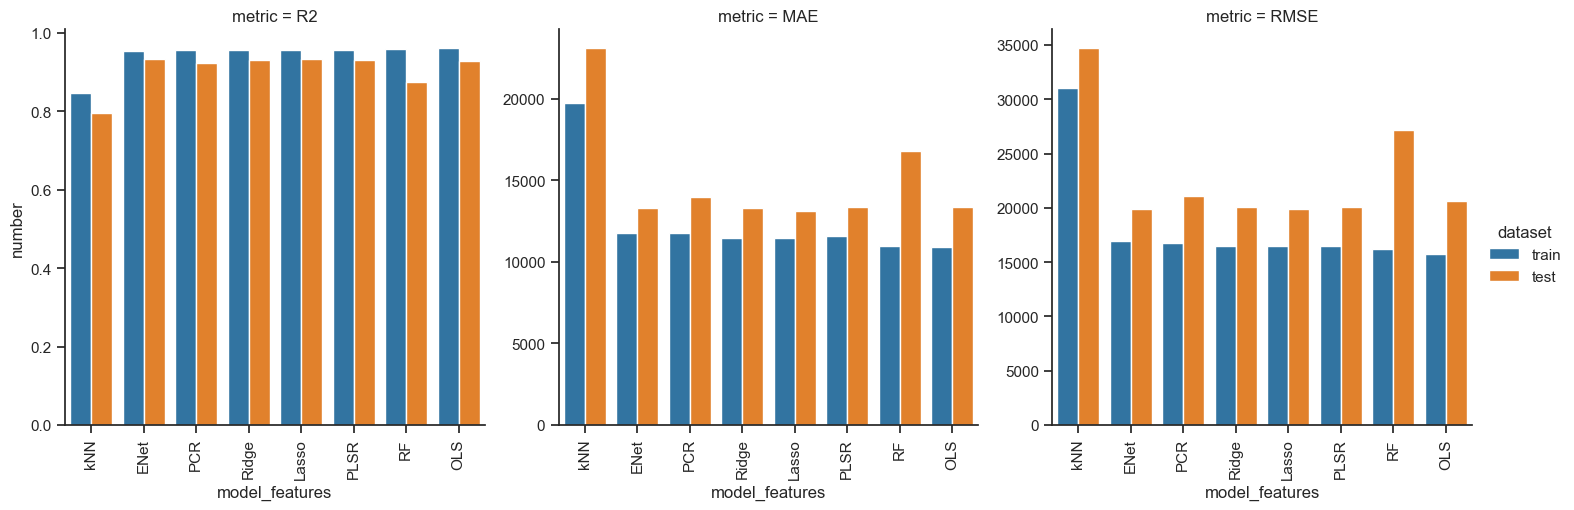

In [13]:
# compare train vs test scores
def combine_train_test_res_df(df_train_scores, df_test_scores):
    df = rearrange_df(df_train_scores)
    df['dataset'] = 'train'
    df1 = rearrange_df(df_test_scores)
    df1['dataset'] = 'test'
    return pd.concat([df, df1], ignore_index=True)

chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=combine_train_test_res_df(compare_train, compare_test),
    kind='bar',
    sharey=False,
    hue='dataset'
)
chart.set_xticklabels(rotation=90);

> ## 📝 Key points: Random forests and distance-based methods
> - Random forests can be combined to solve regression tasks
> - kNN is a method that can also be used for regression